In [2]:
import json
from copy import copy
import matplotlib.pyplot as plt
import yaml
import optuna
import numpy as np
from optuna.samplers import CmaEsSampler, TPESampler

from utils import denoise_small_values, generate_sinc_filter, generate_filter, oversample
from snn.resonator import test_resonator_on_chirp, lf_lp_options

In [92]:
from snn.spiking_network import SpikingNetwork
from snn.layers import SCTNLayer
from snn.spiking_neuron import create_SCTN, IDENTITY


def oversample(signal, num_samples):
    original_length = signal.shape[0]
    indices = np.linspace(0, original_length - 1, num_samples)
    interpolated_signal = np.interp(indices, np.arange(original_length), signal)
    return interpolated_signal

def neuron_output(neuron, rolling_window, duration, signal_freq, shift_degrees=0):
    y_events = neuron.out_spikes()
    cycles = 5
    samples_per_cycle =  clk_freq / signal_freq
    samples_per_degree = samples_per_cycle/360
    shift_samples = int(shift_degrees*samples_per_degree)
    y_events = y_events[
        (y_events > (duration - ((3+cycles)/signal_freq)) * clk_freq + shift_samples) &
        (y_events < (duration - (3/signal_freq)) * clk_freq + shift_samples)
    ]
    if len(y_events) == 0:
        raise ValueError("No spikes were emit.")
    y_events -= y_events[0]
    y_spikes = np.zeros(int(cycles/signal_freq * clk_freq) + 1)
    y_spikes[y_events] = 1
    y_spikes_rollsum = np.convolve(y_spikes, np.ones(rolling_window, dtype=int), 'valid')
    return y_spikes_rollsum

def generate_and_input_signal(resonator, duration, f):
    x = np.linspace(0, duration, int(duration * resonator.clk_freq))
    t = x * 2 * np.pi * f
    sine_wave = np.sin(t)
    resonator.input_full_data(sine_wave)

def resonator_from_optuna(freq0, lf_lp_option, theta_input, theta, weight_input, weight_feedback, weight, amplitude_gain=1, clk_freq=1_536_000):
    LF, LP, f_resonator = lf_lp_options(freq0, clk_freq)[lf_lp_option]
    network = SpikingNetwork(clk_freq)
    network.add_amplitude(1000 * amplitude_gain)

    # Encode to pdm
    neuron = create_SCTN()
    neuron.activation_function = IDENTITY
    network.add_layer(SCTNLayer([neuron]))

    # SCTN 1
    neuron = create_SCTN()
    neuron.synapses_weights = np.array([weight_input, -weight_feedback], dtype=np.float64)
    neuron.leakage_factor = LF
    neuron.leakage_period = LP
    neuron.theta = theta_input
    neuron.activation_function = IDENTITY
    neuron.membrane_should_reset = False
    network.add_layer(SCTNLayer([neuron]))

    for i in range(3):
        neuron = create_SCTN()
        neuron.synapses_weights = np.array([weight], dtype=np.float64)
        neuron.leakage_factor = LF
        neuron.leakage_period = LP
        neuron.theta = theta
        neuron.activation_function = IDENTITY
        neuron.membrane_should_reset = False
        network.add_layer(SCTNLayer([neuron]))

    # feedback
    network.connect_by_id(4, 1)
    return network

def shift(signal, shift_by, waves):
    delta = np.zeros(len(signal))
    wave_length = len(signal)/waves
    shift_by *= wave_length/(2*np.pi)
    delta[int(shift_by)] = 1.0
    fft_delta = np.fft.fft(delta)
    fft_signal = np.fft.fft(signal)*fft_delta
    shifted_signal = np.fft.ifft(fft_signal)
    return shifted_signal.real

def objective(trial):
    # lf_lp_option=trial.suggest_int('lf_lp_option', 0, len(_lf_lp_options)-1)
    theta_input=trial.suggest_int('theta_input', -30, -1)
    theta=trial.suggest_int('theta', -30, -1)
    weight_input=trial.suggest_int('weight_input', 5, 150)
    weight_feedback=trial.suggest_int('weight_feedback', 5, 150)
    weight=trial.suggest_int('weight', 5, 150)
    # amplitude_gain=trial.suggest_float('amplitude_gain', 0, 10)
    amplitude_gain=1

    resonator = resonator_from_optuna(freq0, lf_lp_option, theta_input, theta, weight_input, weight_feedback, weight, amplitude_gain, clk_freq)
    return  score_resonator(resonator, duration=.3, freq0=freq0)

def score_resonator(resonator, duration, freq0, plot=False):
    for i in range(0, 5):
        resonator.log_out_spikes(i)

    x = np.linspace(0, duration, int(duration * resonator.clk_freq))
    t = x * 2 * np.pi * freq0
    sine_wave = np.sin(t)
    resonator.input_full_data(sine_wave)

    try:
        spikes_roll_shifted = np.array([neuron_output(resonator.neurons[i], spikes_window_size, duration, signal_freq=freq0, shift_degrees=phase_shift[i])
                                for i in range(0, 5)])

        spikes_roll = np.array([neuron_output(resonator.neurons[i], spikes_window_size, duration, signal_freq=freq0)
                                for i in range(0, 5)])
    except ValueError:
        return np.inf

    for i in range(5):
        if spikes_roll[i].max() == spikes_roll[i].min():
            return np.inf
        spikes_roll[i] = (spikes_roll[i] - spikes_roll[i].min()) / (spikes_roll[i].max() - spikes_roll[i].min())*2-1
        spikes_roll_shifted[i] = (spikes_roll_shifted[i] - spikes_roll_shifted[i].min()) / (spikes_roll_shifted[i].max() - spikes_roll_shifted[i].min())*2-1

    if plot:
        # sine_wave = sine_wave[-int((7/freq0) * clk_freq):-int((2/freq0) * clk_freq)+1]
        # sine_shifted = shift(sine_wave, np.pi/4, 5)
        # for i in range(5):
        #     plt.plot(spikes_roll[i], label=f'neuron {i}')
        # for i in range(1, 5):
        i = 3
        plt.plot(spikes_roll[i-1], label=f'input to {i}')
        plt.plot(spikes_roll[i], label=f'output of {i}')
        plt.plot(spikes_roll_shifted[i], label=f'output of {i} shifted')
        # plt.plot(normalize_roll0, label='neuron 0')

        # plt.plot(sine_wave, label='input')
        # plt.plot(sine_shifted, label='input shifted')
        plt.legend()
    mse = 0
    for i in range(1, 5):
        mse += np.abs(spikes_roll_shifted[i] - spikes_roll[i-1]).mean()
    return mse
    # f0f1_amp_spikes_ratio_loss = (max_spikes2 - mean_spikes2) / (max_spikes1 - mean_spikes1)
    # n0n1_mean_spikes_ratio_loss = np.abs(mean_spikes0 / mean_spikes1 - 1)
    # mse_phase_shift = np.sum(np.abs((normalize_roll0 + normalize_roll1)))/len(normalize_roll0)
    #
    # return mse_phase_shift + f0f1_amp_spikes_ratio_loss + n0n1_mean_spikes_ratio_loss

In [93]:
clk_freq = 1536000
lf_lp_options(1014, clk_freq)[4]

array([   4.        ,   14.        , 1018.59163579])

mse 0.21378491714070932


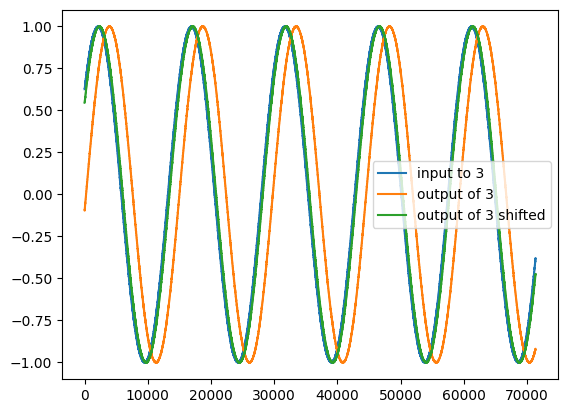

In [106]:
freq0 = 2350
freq_gt = 104
clk_freq = 1536000
duration = .3
spikes_window_size = 2500
lf_lp_option = 4

base_params = {
    'theta_input': -1,
    'theta': -5,
    'weight_input': 11,
    'weight_feedback': 9,
    'weight': 10,
}
resonator = resonator_from_optuna(freq_gt, **base_params, lf_lp_option=5, clk_freq=clk_freq)
# desired_resonator = resonator_from_optuna(freq0, **base_params, lf_lp_option=5, clk_freq=clk_freq)
resonator.log_out_spikes(0)
for i in range(0, 5):
    resonator.log_out_spikes(i)
generate_and_input_signal(resonator, duration, freq_gt)
# generate_and_input_signal(desired_resonator, duration, freq_gt)
# ground_truth_104 = np.array([neuron_output(resonator.neurons[i], spikes_window_size, duration, freq_gt) for i in range(0, 5)])

phase_shift = [0] * 5
# ground_truth = []
for i in range(1, 5):
    j = i - 1
    norm_x0 = (ground_truth_104[j] - np.min(ground_truth_104[j])) / (np.max(ground_truth_104[j]) - np.min(ground_truth_104[j])) * 2 - 1
    norm_x1 = (ground_truth_104[i] - np.min(ground_truth_104[i])) / (np.max(ground_truth_104[i]) - np.min(ground_truth_104[i])) * 2 - 1
    phase_shift[i] = np.mean(np.abs((np.arcsin(norm_x0) - np.arcsin(norm_x1)))*180/np.pi)
    # ground_truth.append()


mse = score_resonator(resonator, duration=.3, freq0=freq_gt, plot=True)
print(f'mse {mse}')

In [107]:
import time

study_name = f'Study{clk_freq}-{freq0}'
study = optuna.create_study(study_name=study_name,
                            pruner=optuna.pruners.HyperbandPruner(),
                            sampler=TPESampler(seed=43),
                            direction='minimize',
                            load_if_exists=True)

[I 2023-06-15 14:00:37,103] A new study created in memory with name: Study1536000-2350


In [108]:
ts = time.time()
study.optimize(objective, n_trials=400)
print(f'{time.time() - ts} seconds.')

[I 2023-06-15 14:00:37,845] Trial 0 finished with value: 3.6025974025974024 and parameters: {'theta_input': -27, 'theta': -12, 'weight_input': 24, 'weight_feedback': 40, 'weight': 52}. Best is trial 0 with value: 3.6025974025974024.
[I 2023-06-15 14:00:38,518] Trial 1 finished with value: 2.8649350649350644 and parameters: {'theta_input': -5, 'theta': -11, 'weight_input': 84, 'weight_feedback': 9, 'weight': 112}. Best is trial 1 with value: 2.8649350649350644.
[I 2023-06-15 14:00:39,188] Trial 2 finished with value: 3.0753246753246755 and parameters: {'theta_input': -19, 'theta': -6, 'weight_input': 42, 'weight_feedback': 13, 'weight': 131}. Best is trial 1 with value: 2.8649350649350644.
[I 2023-06-15 14:00:39,859] Trial 3 finished with value: 3.205194805194805 and parameters: {'theta_input': -24, 'theta': -18, 'weight_input': 51, 'weight_feedback': 16, 'weight': 128}. Best is trial 1 with value: 2.8649350649350644.
[I 2023-06-15 14:00:40,539] Trial 4 finished with value: 2.6363636363

KeyboardInterrupt: 

mse 1.4259740259740261


{'theta_input': -25,
 'theta': -8,
 'weight_input': 67,
 'weight_feedback': 24,
 'weight': 130}

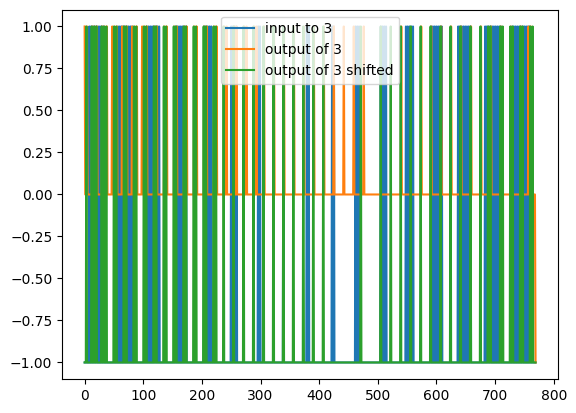

In [109]:
# 118 {'theta_input': -1.161, 'theta': -4.943, 'weight_input': 8.512, 'weight_feedback': 8.867, 'weight': 10.342}
best_params = study.best_params.copy()

resonator = resonator_from_optuna(freq0, **best_params, lf_lp_option=lf_lp_option, clk_freq=clk_freq)
# resonator = resonator_from_optuna(freq0, **base_params, clk_freq=clk_freq)
mse = score_resonator(resonator, duration=.3, freq0=freq0, plot=True)
print(f'mse {mse}')
best_params

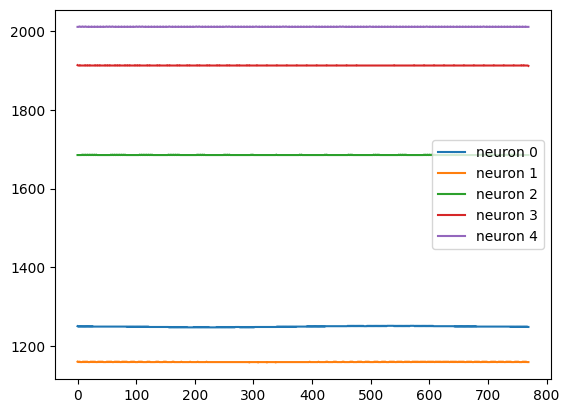

In [110]:
resonator = resonator_from_optuna(freq0, **best_params, lf_lp_option=lf_lp_option, clk_freq=clk_freq)
for i in range(len(resonator.neurons)):
    resonator.log_out_spikes(i)

generate_and_input_signal(resonator, duration, freq0)

for i in range(len(resonator.neurons)):
    try:
        normalize_roll = neuron_output(resonator.neurons[i], spikes_window_size, duration, signal_freq=freq0)
        plt.plot(normalize_roll, label=f'neuron {i}')
    except ValueError:
        plt.plot([0], label=f'neuron {i} didnt emit spikes')

plt.legend()


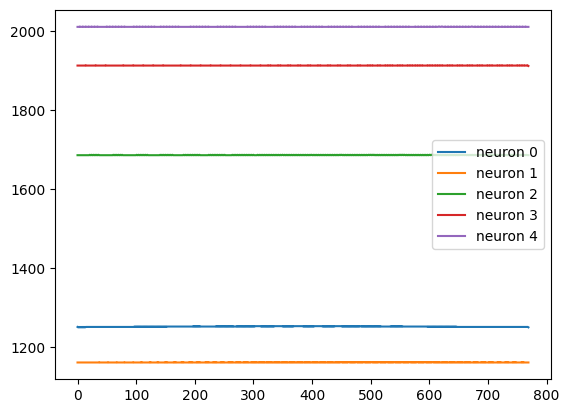

In [111]:
resonator = resonator_from_optuna(freq0, **best_params, lf_lp_option=lf_lp_option, clk_freq=clk_freq)
for i in range(len(resonator.neurons)):
    resonator.log_out_spikes(i)


generate_and_input_signal(resonator, duration, freq0 / 2)

for i in range(len(resonator.neurons)):
    try:
        normalize_roll = neuron_output(resonator.neurons[i], spikes_window_size, duration, signal_freq=freq0)
        plt.plot(normalize_roll, label=f'neuron {i}')
    except ValueError:
        plt.plot([0], label=f'neuron {i} didnt emit spikes')

plt.legend()


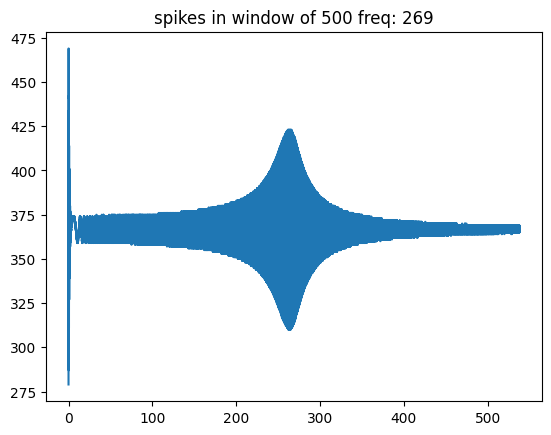

In [88]:
start_freq = 0
spectrum = 2 * freq0
resonator = resonator_from_optuna(freq0, **best_params, lf_lp_option=lf_lp_option, clk_freq=clk_freq)
# resonator = resonator_from_optuna(freq0, **base_params, lf_lp_option=lf_lp_option, clk_freq=clk_freq)
resonator.log_out_spikes(-1)

step = 1 / 20000
test_size = int(spectrum / step)
test_resonator_on_chirp(
    resonator,
    start_freq=start_freq,
    step=step,
    test_size=test_size,
    clk_freq=clk_freq
)

spikes_neuron = resonator.neurons[-1]
y_events = spikes_neuron.out_spikes()
y_spikes = np.zeros(test_size)
y_spikes[y_events] = 1
spikes_window_size = 500
y_spikes = np.convolve(y_spikes, np.ones(spikes_window_size, dtype=int), 'valid')
x = np.linspace(start_freq, start_freq+spectrum, len(y_spikes))
plt.title(f'spikes in window of {spikes_window_size} freq: {freq0}')
plt.plot(x, y_spikes)
plt.show()

In [348]:
def n0n5_resonator(lf_lp_option, theta_input, theta, weight_input, weight_feedback, weight, amplitude_gain=1, clk_freq=1_536_000):
    LF, LP, f_resonator = _lf_lp_options[lf_lp_option]
    network = SpikingNetwork(clk_freq)
    network.add_amplitude(1000 * amplitude_gain)

    # Encode to pdm
    neuron = create_SCTN()
    neuron.activation_function = IDENTITY
    network.add_layer(SCTNLayer([neuron]))

    neuron = create_SCTN()
    neuron.synapses_weights = np.array([weight_input, -weight_feedback], dtype=np.float64)
    neuron.leakage_factor = LF
    neuron.leakage_period = LP
    neuron.theta = theta_input
    neuron.activation_function = IDENTITY
    neuron.membrane_should_reset = False
    network.add_layer(SCTNLayer([neuron]))

    for i in range(3):
        neuron = create_SCTN()
        neuron.synapses_weights = np.array([weight], dtype=np.float64)
        neuron.leakage_factor = LF
        neuron.leakage_period = LP
        neuron.theta = theta
        neuron.activation_function = IDENTITY
        neuron.membrane_should_reset = False
        network.add_layer(SCTNLayer([neuron]))

    neuron = create_SCTN()
    neuron.synapses_weights = np.array([.5*weight, .5*weight], dtype=np.float64)
    neuron.leakage_factor = LF
    neuron.leakage_period = LP
    neuron.theta = theta
    neuron.activation_function = IDENTITY
    neuron.membrane_should_reset = False
    network.add_layer(SCTNLayer([neuron]))

    # feedback
    network.connect_by_id(4, 1)
    network.connect_by_id(1, 5)
    return network

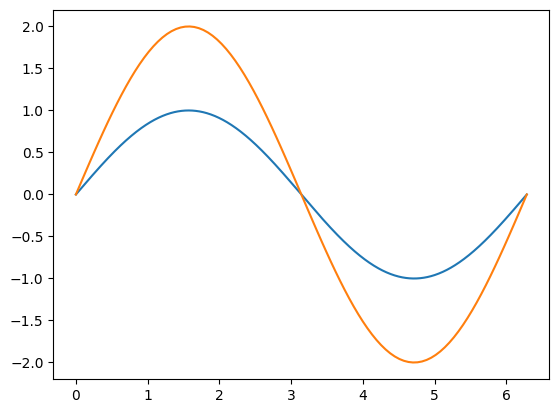

In [424]:
import numpy as np


original_signal = np.sin(np.linspace(0, 2*np.pi, 1000))
interpolated_signal = oversample(original_signal, 100)*2
plt.plot(np.linspace(0, 2*np.pi, 1000), original_signal)
plt.plot(np.linspace(0, 2*np.pi, 100), interpolated_signal)